# Exploration des données de Sirene

## Importation des différents packages nécessaires.

In [247]:
import pandas as pd
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import random
import itertools
import numpy as np
from datetime import datetime
from tqdm import tqdm
import nltk
import string
import swifter
from nltk.corpus import stopwords
import fasttext
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')

ModuleNotFoundError: No module named 'dask_ml'

## Importation des données

In [257]:
DBRaw = dd.read_parquet('../data/extraction_sirene_20220510.parquet', engine='pyarrow')

Temporaire : On restreint les données à 1% de la base initiales.

In [258]:
#DBRaw = DBRaw.sample(frac= 0.01, random_state=1234)

On transforme les valeurs manquantes en NaN.

In [220]:
DBRaw = DBRaw.fillna(value=np.nan)

On garde seulement les variables potentiellement intéressantes : 
- ``APE_SICORE :`` Code APE (Activité Principale Exercée) retenu lors du traitement de codification (soit Sicore soit gestionnaire) ;
- ``NAT_SICORE :`` Nature de l'activité de l'entreprise ;
- ``SED_SICORE :`` Sédentarité de l'entreprise ;
- ``EVT_SICORE :`` Sédentarité de l'entreprise ;
- ``LIB_SICORE :`` Sédentarité de l'entreprise ;
- ``DATE :`` Sédentarité de l'entreprise ;
- ``AUTO :`` Type de liasse extrait de la base brute Sirène ;
- ``SURF :`` Surface en $m^2$ de l'établissement.


In [221]:
Var2Keep = ["APE_SICORE","LIB_SICORE","AUTO","DATE","NAT_SICORE","SED_SICORE","EVT_SICORE","SURF"]
DB = DBRaw[Var2Keep]

On supprime les liasses où une valeur est manquante pour l'une de ces deux variables (6.77% de la base). Il s'agit principalement du code APE donc il n'est pas nécessaire de l'imputer.

In [222]:
DB = DB.dropna(subset=['APE_SICORE'])  

On a finalement 10.8 millions de liasses.

In [223]:
DB.shape[0].compute()

10887847

## I- Modèle 1

On estime un modèle FastText standard en utilisant seulement les libellés comme features.

### 1) Preprocessing 

In [224]:
DB1 = DB[["APE_SICORE","LIB_SICORE"]]
DB1 = DB1.dropna(subset=['LIB_SICORE'])  

In [225]:
stopwords_ = set(stopwords.words('french') + ['a'])
def CleanLib(lib):
    # On supprime toutes les ponctuations
    lib = lib.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # On supprime tous les chiffres
    lib = lib.translate(str.maketrans(string.digits, ' ' * len(string.digits)))

    # On supprime les stopwords et on renvoie les mots en majuscule
    return " ".join([x.lower() for x in lib.split() if x.lower() not in stopwords_])

In [226]:
DB1["LIB_CLEAN"] = DB1["LIB_SICORE"].apply(lambda x: CleanLib(x), meta=pd.Series(dtype='str', name='LIB_CLEAN'))
df = DB1.compute()

### 2) Splitting

On mélange de manière aléatoire les index puis on les divise en 2 groupes selon un certain pourcentage (ici 80% et 20%)


In [227]:
random.seed(123456)
Idx = random.sample(df.index.values.tolist(), df.shape[0])
Groups = np.split(Idx, [int(len(Idx)*0.8)])

In [228]:
with open("../data/train_text.txt", 'w') as f:
    for idx in range(len(Groups[0])):
        aLine = "__label__{} {}".format(df.at[Groups[0][idx],"APE_SICORE"], df.at[Groups[0][idx],"LIB_CLEAN"])
        f.write("%s\n" % aLine)


### 3) Training

On définit plusieurs options pour le modèle.

In [229]:
config_fasttext={"dim": 150,
"lr": 0.2,
"epoch": 80,
"wordNgrams": 3,
"minn": 3,
"maxn": 4,
"minCount": 3,
"bucket": 3000000,
"thread": 25,
"loss": 'ova',
"label_prefix": '__label__'}

In [230]:
model1 = fasttext.train_supervised(input="../data/train_text.txt", **config_fasttext)
#model1 = fasttext.load_model("../models/fasttextmodel1.bin")

Read 62M words
Number of words:  56089
Number of labels: 727
Progress: 100.0% words/sec/thread:   10583 lr:  0.000000 avg.loss:  1.697424 ETA:   0h 0m 0s  0.9% words/sec/thread:   10750 lr:  0.198260 avg.loss:  2.567585 ETA:   5h 8m14s 8m43s  1.1% words/sec/thread:   10788 lr:  0.197822 avg.loss:  3.465041 ETA:   5h 6m29s 0.197219 avg.loss:  4.308239 ETA:   5h 2m54s  1.5% words/sec/thread:   10846 lr:  0.197072 avg.loss:  4.507812 ETA:   5h 3m41s  2.6% words/sec/thread:   10667 lr:  0.194735 avg.loss:  4.417874 ETA:   5h 5m 7s  2.7% words/sec/thread:   10656 lr:  0.194660 avg.loss:  4.421676 ETA:   5h 5m20s 4.231048 ETA:   4h55m46s ETA:   4h54m43s29s 4.152184 ETA:   4h48m29sh48m40s  5.7% words/sec/thread:   10914 lr:  0.188533 avg.loss:  4.143776 ETA:   4h48m44s  4h48m48s 0.187403 avg.loss:  4.078829 ETA:   4h48m34s 4.034964 ETA:   4h45m49s  7.7% words/sec/thread:   10860 lr:  0.184563 avg.loss:  4.009751 ETA:   4h44m 2s  8.1% words/sec/thread:   10786 lr:  0.183808 avg.loss:  3.993657

### Evaluation du modèle

In [231]:
def get_pred(lib, mod):
    out = mod.predict(lib)
    pred = out[0][0].replace("__label__","")
    prob = out[1][0]
    return [pred, prob]

In [232]:
df = df.rename(columns={"APE_SICORE":"APE_NIV5"})

Accuracy of the training set

In [233]:
df_train = df.loc[Groups[0], :]
df_train[['PREDICTION_NIV5', 'PROBA']] = df_train['LIB_CLEAN'].swifter.apply(lambda x: get_pred(x, model1)).to_list()
df_train['GoodPREDICTION'] = df_train['APE_NIV5'] == df_train['PREDICTION_NIV5']
for i in range(2,5):
    df_train['PREDICTION_NIV'+ str(i)] = df_train['PREDICTION_NIV5'].str[:i]
    
sum(df_train['GoodPREDICTION'])/df_train.shape[0] * 100

Pandas Apply:   0%|          | 0/8710165 [00:00<?, ?it/s]

86.14177802601903

Accuracy of the testing set

In [234]:
df_test = df.loc[Groups[1], :]
df_test[['PREDICTION_NIV5', 'PROBA']] = df_test['LIB_CLEAN'].swifter.apply(lambda x: get_pred(x, model1)).to_list()
df_test['GoodPREDICTION'] = df_test['APE_NIV5'] == df_test['PREDICTION_NIV5']
for i in range(2,5):
    df_test['PREDICTION_NIV'+ str(i)] = df_test['PREDICTION_NIV5'].str[:i]

sum(df_test['GoodPREDICTION'])/df_test.shape[0] * 100

Pandas Apply:   0%|          | 0/2177542 [00:00<?, ?it/s]

80.45447573456677

On importe un document qui contient des informations sur les différents codes APE

In [235]:
df_naf =  pd.read_csv(r"../data/naf_extended.csv",sep=",",encoding="utf-8",dtype=str)
df_naf[["NIV3","NIV4","NIV5"]] = df_naf[["NIV3","NIV4","NIV5"]].apply(lambda x: x.str.replace('.', ''))
df_naf.set_index("NIV5", inplace=True, drop=False)

On calcule la prédiction pour le niveau 1 grâce à la table importée

In [236]:
df_test['PREDICTION_NIV1'] = df_test["PREDICTION_NIV2"].swifter.apply(lambda x : pd.unique(df_naf["NIV1"][df_naf["NIV2"]== x])[0])
df_train['PREDICTION_NIV1'] = df_train["PREDICTION_NIV2"].swifter.apply(lambda x : pd.unique(df_naf["NIV1"][df_naf["NIV2"]== x])[0])

Pandas Apply:   0%|          | 0/2177542 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8710165 [00:00<?, ?it/s]

On regarde la precision, le rappel et le F1 pour tous les différentes sous catégories du code APE

In [237]:
for aNiv in tqdm(["NIV1","NIV2","NIV3","NIV4"]):
    df_test["APE_" + aNiv] = df_test["APE_NIV5"].apply(lambda x : df_naf.loc[x][aNiv])
    df_train["APE_" + aNiv] = df_train["APE_NIV5"].apply(lambda x : df_naf.loc[x][aNiv])

100%|██████████| 4/4 [31:04<00:00, 466.11s/it]


In [238]:
def get_results(naf, train, test):
    Results = dict()
    for aNiv in ["NIV1","NIV2","NIV3", "NIV4", "NIV5"]:
        Results[aNiv] = train.groupby(['APE_'+ aNiv]).size().rename("Size_TRAIN").to_frame()
        Results[aNiv] = Results[aNiv].join(test.groupby(['APE_'+ aNiv]).size().rename("Size_TEST").to_frame())
        Results[aNiv] = Results[aNiv].join(test.groupby(['APE_'+ aNiv]).mean('GoodPREDICTION').rename(columns={"GoodPREDICTION":"Recall_TEST"}))
        Results[aNiv] = Results[aNiv].join(test.groupby(['PREDICTION_'+ aNiv]).mean('GoodPREDICTION').rename(columns={"GoodPREDICTION":"Precision_TEST"}))
        Results[aNiv] = Results[aNiv].join(2 * 1/(1/Results[aNiv]["Precision_TEST"] + 1/Results[aNiv]["Recall_TEST"]).rename("F1_TEST").to_frame())
        Results[aNiv]["LIB_"+ aNiv] = [pd.unique(naf["LIB_"+ aNiv][naf[aNiv]== x])[0] for x in Results[aNiv].index.values]

    return Results

In [239]:
Results = get_results(df_naf, df_train, df_test)

In [240]:
Results["NIV5"]

,Size_TRAIN,Size_TEST,Recall_TEST,Precision_TEST,F1_TEST,LIB_NIV5
APE_NIV5,,,,,,
0111Z,31586,7924.0,0.955326,0.360048,0.522989,"Culture de céréales (à l'exception du riz), de..."
0112Z,24,6.0,0.333333,1.000000,0.500000,Culture du riz
0113Z,17286,4426.0,0.911884,0.953686,0.932317,"Culture de légumes, de melons, de racines et d..."
0114Z,999,253.0,0.833992,0.985981,0.903640,Culture de la canne à sucre
0115Z,48,16.0,0.125000,1.000000,0.222222,Culture du tabac
...,...,...,...,...,...,...
9602B,78065,19617.0,0.949483,0.950209,0.949846,Soins de beauté
9603Z,7798,1991.0,0.921647,0.909767,0.915669,Services funéraires
9604Z,29608,7398.0,0.706002,0.794856,0.747799,Entretien corporel


On calcule les matrices de confusion pour chaque catégories et sous catégorie afin de vérifier la prédiction au sein d'une même catégorie.

In [241]:
def get_matrix(test, cat, mod):
    sub_cat = "NIV" + str(int(cat[-1]) + 1 )
    filtered_df = df_test[(df_test["APE_" + cat] == mod) & (df_test["PREDICTION_" + cat] == mod)]
    cm = confusion_matrix(filtered_df["APE_" + sub_cat].to_list(), filtered_df["PREDICTION_" + sub_cat].to_list(), normalize = 'true')
    return cm

On regarde d'abord au niveau le plus aggrégé.

<AxesSubplot:>

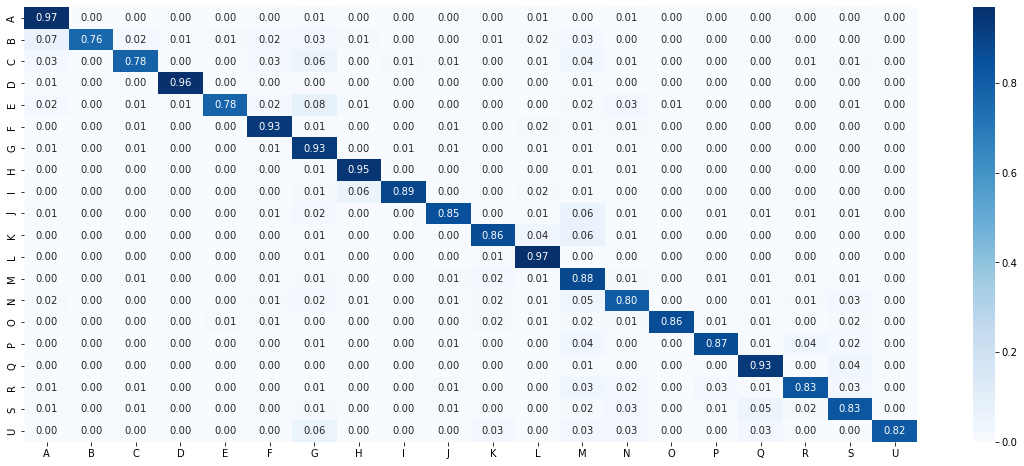

In [242]:
target_names = np.sort(pd.unique(df_test["APE_NIV1"]))
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(confusion_matrix(df_test["APE_NIV1"].to_list(), df_test["PREDICTION_NIV1"].to_list(), normalize = 'true'),
             annot=True, fmt='.2f',cmap='Blues', xticklabels=target_names, yticklabels=target_names)

Ensuite on peut regarder les résultats au sein de chaque sous catégorie. Ci-dessous on s'intéresse à la ligne "G" et on vérifie comment sont prédit les codes au sein de cette catégorie.

In [243]:
ConfMatrices = {aNiv : {mod : get_matrix(df_test, aNiv, mod) for mod in pd.unique(df_test["APE_" + aNiv])} for aNiv in ["NIV1","NIV2","NIV3","NIV4"]}

<AxesSubplot:>

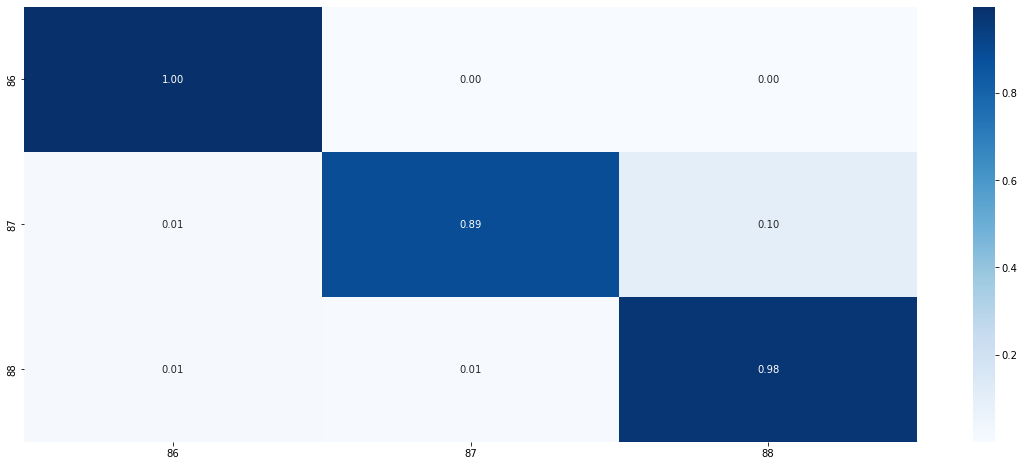

In [244]:
aNiv = "NIV1"
aMod = "Q"

aSubNiv = "NIV" + str(int(aNiv[-1]) + 1 )
target_names = np.sort(pd.unique(df_test["APE_" + aSubNiv][df_test["APE_" + aNiv] == aMod]))
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(ConfMatrices[aNiv][aMod], annot=True, fmt='.2f',cmap='Blues', xticklabels=target_names, yticklabels=target_names)


- hyper parametres
- checker les libellés, leurs qualité, stats descr 

In [261]:
def clean_lib(lib):
    # On supprime toutes les ponctuations
    lib = lib.translate(
        str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    )
    # On supprime tous les chiffres
    lib = lib.translate(
        str.maketrans(string.digits, ' ' * len(string.digits))
    )

    # On supprime les stopwords et on renvoie les mots en majuscule
    return " ".join([x.lower() for x in lib.split() if x.lower() not in stopwords_])


def run_preprocessing(ddf):
    """
    Preprocess the input data
    """
    # On se restreint à nos deux variables d'intérêt
    ddf = ddf[["APE_SICORE", "LIB_SICORE"]]

    # On définit les valeurs manquantes comme des NaN
    ddf = ddf.fillna(value=np.nan)

    # On supprime les valeurs manquantes
    ddf = ddf.dropna()

    ddf["LIB_CLEAN"] = ddf["LIB_SICORE"].apply(lambda x: clean_lib(x),
                                               meta=pd.Series(dtype='str',
                                               name='LIB_CLEAN'))

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(ddf["LIB_CLEAN"],
                                                        ddf["APE_SICORE"],
                                                        test_size=0.2,
                                                        random_state=0)
    return X_train, X_test, y_train, y_test


def get_pred(lib: str, mod: fasttext.FastText):
    """
    Returns the prediction of model `mod` on text `lib`
    along with the output probability.

    Args:
        lib: Text description.
        mod: Model.

    Returns:
        List: List with the prediction and probability for the
            given text.
    """
    out = mod.predict(lib)
    pred = out[0][0].replace("__label__", "")
    prob = out[1][0]
    return [pred, prob]

def run_training(X_train, y_train, dim, epoch, wordNgrams):

    # train the model with training_data
    with open("../data/train_text.txt", "w") as f:
        for x, y in zip(X_train, y_train):
            formatted_item = "__label__{} {}".format(
                y,x
            )
            f.write("%s\n" % formatted_item)

    model = fasttext.train_supervised(
        "../data/train_text.txt", dim=dim, epoch=epoch,
        wordNgrams=wordNgrams
    )
    return model


def run_prediction(df_test, df_train, mod):

    # predict testing data
    df_test[['PREDICTION_NIV5', 'PROBA']] = df_test['LIB_CLEAN'].apply(
        lambda x: get_pred(x, mod)).to_list()
    df_test['GoodPREDICTION'] = df_test['APE_NIV5'] == df_test['PREDICTION_NIV5']
    for i in range(2, 5):
        df_test['PREDICTION_NIV' + str(i)] = df_test['PREDICTION_NIV5'].str[:i]

    # predict training data
    df_train[['PREDICTION_NIV5', 'PROBA']] = df_train['LIB_CLEAN'].apply(
        lambda x: get_pred(x, mod)).to_list()
    df_train['GoodPREDICTION'] = df_train['APE_NIV5'] == df_train['PREDICTION_NIV5']
    for i in range(2, 5):
        df_train['PREDICTION_NIV' + str(i)] = df_train['PREDICTION_NIV5'].str[:i]

    return df_test, df_train

In [ ]:
ddf = dd.read_parquet(data_url, engine='pyarrow')


In [259]:
# Preprocess data
X_train, X_test, y_train, y_test = run_preprocessing(DBRaw)

In [262]:
# Run training of the model
model = run_training(X_train, y_train, 10, 4, 4)

Read 0M words
Number of words:  15463
Number of labels: 643
Progress: 100.0% words/sec/thread:   11730 lr:  0.000000 avg.loss:  3.815387 ETA:   0h 0m 0s


In [264]:
X_train

Dask Series Structure:
npartitions=1
    object
       ...
Name: LIB_CLEAN, dtype: object
Dask Name: split, 11 tasks

In [265]:
y_train

Dask Series Structure:
npartitions=1
    object
       ...
Name: APE_SICORE, dtype: object
Dask Name: split, 11 tasks

In [273]:
X_test.compute()

LIA_NUM
U69074630297                                        coursier velo
G33826332360                      loueur meuble non professionnel
C92016034838    realisation missions coaching conseil particul...
M63013106504                                traitement charpentes
C13106127208    conseil entreprises specifications procedures ...
                                      ...                        
I75640205929                                 vente correspondance
I75690262887                                 vente correspondance
O00075913994                                                    b
M2B027106401                                           patisserie
G31528482954                           courtier prets immobiliers
Name: LIB_CLEAN, Length: 22054, dtype: object

In [272]:
df_test = pd.merge(X_test.compute(), y_test.compute())


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [263]:
df_train = dd.multi.merge(X_train, y_train).compute()
df_test = dd.merge(X_test, y_test).compute()


AttributeError: 'Series' object has no attribute 'merge'

In [ ]:

# Run training of the model
df_test, df_train = run_prediction(df_test, df_train, model)

# calculate accuracy on test data
accuracy_test = sum(df_test['GoodPREDICTION'])/df_test.shape[0] * 100
# calculate accuracy on train data
accuracy_train = sum(df_train['GoodPREDICTION'])/df_train.shape[0] * 100